In [1]:
import pandas as pd

X = pd.DataFrame({'city':['tokyo', None, 'london', 'seattle', 'san francisco', 'tokyo'],
                 'boolean': ['yes', 'no', None, 'no', 'no', 'yes'],
                 'ordinal_column': ['somewhat like', 'like', 'somewhat like', 'like', 'somewhat like', 'dislike'],
                 'quantitative_column': [1, 11, -.5, 10, None, 20]})

print(X)

            city boolean ordinal_column  quantitative_column
0          tokyo     yes  somewhat like                  1.0
1           None      no           like                 11.0
2         london    None  somewhat like                 -0.5
3        seattle      no           like                 10.0
4  san francisco      no  somewhat like                  NaN
5          tokyo     yes        dislike                 20.0


In [2]:
X.isnull().sum()

city                   1
boolean                1
ordinal_column         0
quantitative_column    1
dtype: int64

In [8]:
X['city'].value_counts().index[0]

'tokyo'

In [9]:
#对于分类数据中的缺失值使用最常见的数据来进行填充
X['city'].fillna(X['city'].value_counts().index[0])

0            tokyo
1            tokyo
2           london
3          seattle
4    san francisco
5            tokyo
Name: city, dtype: object

In [10]:
###自定义转换器
from sklearn.base import TransformerMixin

class CustomCategoryImputer(TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols
    
    def transform(self, df):
        X = df.copy()
        for col in self.cols:
            X[col].fillna(X[col].value_counts().index[0], inplace=True)
        return X
    
    def fit(self, *_):
        return self

In [11]:
cci = CustomCategoryImputer(cols=['city', 'boolean'])

In [12]:
cci.fit_transform(X)

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,1.0
1,tokyo,no,like,11.0
2,london,no,somewhat like,-0.5
3,seattle,no,like,10.0
4,san francisco,no,somewhat like,NaN
5,tokyo,yes,dislike,20.0


In [13]:
from sklearn.impute import SimpleImputer

class CustomQuantitativeImputer(TransformerMixin):
    def __init__(self, cols=None, strategy='mean'):
        self.cols = cols
        self.strategy = strategy
    
    def transform(self, df):
        X = df.copy()
        imputer = SimpleImputer(strategy=self.strategy)
        for col in self.cols:
            X[col] = imputer.fit_transform(X[[col]])
        return X
    
    def fit(self, *_):
        return self

In [14]:
cqi = CustomQuantitativeImputer(cols=['quantitative_column'], strategy='mean')

In [15]:
cqi.fit_transform(X)

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,1.0
1,None,no,like,11.0
2,london,None,somewhat like,-0.5
3,seattle,no,like,10.0
4,san francisco,no,somewhat like,8.3
5,tokyo,yes,dislike,20.0


In [20]:
from sklearn.pipeline import Pipeline

imputer = Pipeline([('quant', cqi), ('category', cci)])
imputer.fit_transform(X)

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,1.0
1,tokyo,no,like,11.0
2,london,no,somewhat like,-0.5
3,seattle,no,like,10.0
4,san francisco,no,somewhat like,8.3
5,tokyo,yes,dislike,20.0


In [21]:
X

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,1.0
1,None,no,like,11.0
2,london,None,somewhat like,-0.5
3,seattle,no,like,10.0
4,san francisco,no,somewhat like,NaN
5,tokyo,yes,dislike,20.0


In [22]:
pd.get_dummies(X, columns=['city', 'boolean'], prefix_sep='__')

,ordinal_column,quantitative_column,city__london,city__san francisco,city__seattle,city__tokyo,boolean__no,boolean__yes
0,somewhat like,1.0,0,0,0,1,0,1
1,like,11.0,0,0,0,0,1,0
2,somewhat like,-0.5,1,0,0,0,0,0
3,like,10.0,0,0,1,0,1,0
4,somewhat like,NaN,0,1,0,0,1,0
5,dislike,20.0,0,0,0,1,0,1


In [23]:
class CustomEncoder(TransformerMixin):
    def __init__(self, col, ordering=None):
        self.ordering = ordering
        self.col = col
    
    def transform(self, df):
        X = df.copy()
        X[self.col] = X[self.col].map(lambda x: self.ordering.index(x))
        
        return X
    
    def fit(self, *_):
        return self

ce = CustomEncoder(col='ordinal_column', ordering=['dislike', 'somewhat like', 'like'])

ce.fit_transform(X)

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,1,1.0
1,None,no,2,11.0
2,london,None,1,-0.5
3,seattle,no,2,10.0
4,san francisco,no,1,NaN
5,tokyo,yes,0,20.0


In [24]:
###将连续特征分箱
#比如年龄这种数据，年龄段会更有用

pd.cut(X['quantitative_column'], bins=3)

0     (-0.52, 6.333]
1    (6.333, 13.167]
2     (-0.52, 6.333]
3    (6.333, 13.167]
4                NaN
5     (13.167, 20.0]
Name: quantitative_column, dtype: category
Categories (3, interval[float64]): [(-0.52, 6.333] < (6.333, 13.167] < (13.167, 20.0]]

In [26]:
pd.cut(X['quantitative_column'], bins=3, labels=False)

0    0.0
1    1.0
2    0.0
3    1.0
4    NaN
5    2.0
Name: quantitative_column, dtype: float64

In [27]:
class CustomCutter(TransformerMixin):
    def __init__(self, col, bins, labels=False):
        self.labels = labels
        self.bins = bins
        self.col = col
    
    def transform(self, df):
        X = df.copy()
        X[self.col] = pd.cut(X[self.col], bins=self.bins, labels=self.labels)
        return X
    
    def fit(self, *_):
        return self

In [28]:
cc = CustomCutter(col='quantitative_column', bins=3)

cc.fit_transform(X)

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,0.0
1,None,no,like,1.0
2,london,None,somewhat like,0.0
3,seattle,no,like,1.0
4,san francisco,no,somewhat like,NaN
5,tokyo,yes,dislike,2.0


In [30]:
pipe = Pipeline([('imputer', imputer), ('encode', ce), ('cut', cc)])
print(X)
pipe.fit(X)

pipe.transform(X)

            city boolean ordinal_column  quantitative_column
0          tokyo     yes  somewhat like                  1.0
1           None      no           like                 11.0
2         london    None  somewhat like                 -0.5
3        seattle      no           like                 10.0
4  san francisco      no  somewhat like                  NaN
5          tokyo     yes        dislike                 20.0


,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,1,0
1,tokyo,no,2,1
2,london,no,1,0
3,seattle,no,2,1
4,san francisco,no,1,1
5,tokyo,yes,0,2


In [33]:
pd.get_dummies(X, columns=['city', 'boolean'], prefix_sep='__')

,ordinal_column,quantitative_column,city__london,city__san francisco,city__seattle,city__tokyo,boolean__no,boolean__yes
0,somewhat like,1.0,0,0,0,1,0,1
1,like,11.0,0,0,0,0,1,0
2,somewhat like,-0.5,1,0,0,0,0,0
3,like,10.0,0,0,1,0,1,0
4,somewhat like,NaN,0,1,0,0,1,0
5,dislike,20.0,0,0,0,1,0,1


In [35]:
import matplotlib.pyplot as plt

In [36]:
plt.rcParams["font.sans-serif"] = ['SimHei']

Text(0.5, 1.0, '和哈哈')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
/Users/lvsongke/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 21644 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/lvsongke/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 21704 missing from current font.
  font.set_text(s, 0.0, flags=flags)
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
/Users/lvsongke/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 21644 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/lvsongke/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 21704 missing from current font.
  font.set_text(s, 0, flags=flags)


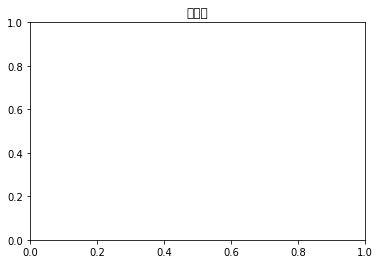

In [37]:
plt.title('和哈哈')

In [38]:
# 特征组合
df = pd.read_csv('data/activity_recognizer/1.csv', names=['index', 'x', 'y', 'z', 'activity'])

df.head()

,index,x,y,z,activity
0,0.0,1502,2215,2153,1
1,1.0,1667,2072,2047,1
2,2.0,1611,1957,1906,1
3,3.0,1601,1939,1831,1
4,4.0,1643,1965,1879,1


In [39]:
df.activity.value_counts(normalize=True)

7    0.515369
1    0.207242
4    0.165291
3    0.068793
5    0.019637
6    0.017951
2    0.005711
0    0.000006
Name: activity, dtype: float64

In [40]:
##建立模型
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

X = df[['x', 'y', 'z']]
y = df['activity']

print(X)
print(y)

           x     y     z
0       1502  2215  2153
1       1667  2072  2047
2       1611  1957  1906
3       1601  1939  1831
4       1643  1965  1879
...      ...   ...   ...
162496  1927  2388  2074
162497  1930  2383  2074
162498  1929  2385  2076
162499  1926  2385  2078
162500  1922  2387  2078

[162501 rows x 3 columns]
0         1
1         1
2         1
3         1
4         1
         ..
162496    7
162497    7
162498    7
162499    7
162500    0
Name: activity, Length: 162501, dtype: int64


In [44]:
knn_params = {'n_neighbors': [3,5]}

knn = KNeighborsClassifier()
grid = GridSearchCV(knn, knn_params)
grid.fit(X, y)
print(grid.best_score_, grid.best_params_)

/Users/lvsongke/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


0.7408140649873495 {'n_neighbors': 5}


In [47]:
##多项式特征
from sklearn.preprocessing import PolynomialFeatures   ##(生成新的特征组合矩阵)

poly = PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)

X_poly = poly.fit_transform(X)
# X_poly[:5]
pd.DataFrame(X_poly, columns=poly.get_feature_names()).head()

,1,x0,x1,x2,x0^2,x0 x1,x0 x2,x1^2,x1 x2,x2^2
0,1.0,1502.0,2215.0,2153.0,2256004.0,3326930.0,3233806.0,4906225.0,4768895.0,4635409.0
1,1.0,1667.0,2072.0,2047.0,2778889.0,3454024.0,3412349.0,4293184.0,4241384.0,4190209.0
2,1.0,1611.0,1957.0,1906.0,2595321.0,3152727.0,3070566.0,3829849.0,3730042.0,3632836.0
3,1.0,1601.0,1939.0,1831.0,2563201.0,3104339.0,2931431.0,3759721.0,3550309.0,3352561.0
4,1.0,1643.0,1965.0,1879.0,2699449.0,3228495.0,3087197.0,3861225.0,3692235.0,3530641.0


In [48]:
##多项式特征
from sklearn.preprocessing import PolynomialFeatures   ##(生成新的特征组合矩阵)

poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)

X_poly = poly.fit_transform(X)
# X_poly[:5]
pd.DataFrame(X_poly, columns=poly.get_feature_names()).head()

,x0,x1,x2,x0^2,x0 x1,x0 x2,x1^2,x1 x2,x2^2
0,1502.0,2215.0,2153.0,2256004.0,3326930.0,3233806.0,4906225.0,4768895.0,4635409.0
1,1667.0,2072.0,2047.0,2778889.0,3454024.0,3412349.0,4293184.0,4241384.0,4190209.0
2,1611.0,1957.0,1906.0,2595321.0,3152727.0,3070566.0,3829849.0,3730042.0,3632836.0
3,1601.0,1939.0,1831.0,2563201.0,3104339.0,2931431.0,3759721.0,3550309.0,3352561.0
4,1643.0,1965.0,1879.0,2699449.0,3228495.0,3087197.0,3861225.0,3692235.0,3530641.0


In [49]:
##多项式特征
from sklearn.preprocessing import PolynomialFeatures   ##(生成新的特征组合矩阵)

poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)

X_poly = poly.fit_transform(X)
# X_poly[:5]
pd.DataFrame(X_poly, columns=poly.get_feature_names()).head()

,x0,x1,x2,x0 x1,x0 x2,x1 x2
0,1502.0,2215.0,2153.0,3326930.0,3233806.0,4768895.0
1,1667.0,2072.0,2047.0,3454024.0,3412349.0,4241384.0
2,1611.0,1957.0,1906.0,3152727.0,3070566.0,3730042.0
3,1601.0,1939.0,1831.0,3104339.0,2931431.0,3550309.0
4,1643.0,1965.0,1879.0,3228495.0,3087197.0,3692235.0


In [50]:
"""
degree:表示多项式的阶数，
include_bias：true:产生一列全是1的，阶数为0的偏差列，
interaction_only：True：不计算自身，不会得到X0*X0，Y0*Y0这样的，False：则会计算自身
"""


'\ndegree:表示多项式的阶数，\ninclude_bias：true:产生一列全是1的，阶数为0的偏差列，\ninteraction_only：True：不计算自身，不会得到X0*X0，Y0*Y0这样的，False：则会计算自身\n'

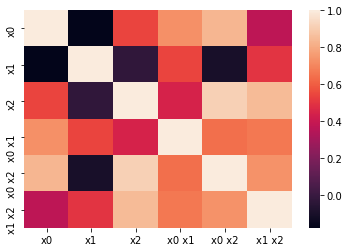

In [52]:
##进行探索性数据分析(EDA)
%matplotlib inline
import seaborn as sns

sns.heatmap(pd.DataFrame(X_poly, columns=poly.get_feature_names()).corr()) ##corr 返回协方差矩阵

In [53]:
pipe_params = {'poly_features__degree': [1,2,3], 'poly_features__interaction_only': [True, False], 'classify__n_neighbors': [3,4,5,6]}

from sklearn.pipeline import Pipeline

pipe = Pipeline([('poly_features', poly), ('classify', knn)])

grid = GridSearchCV(pipe, pipe_params)
grid.fit(X, y)

print(grid.best_score_, grid.best_params_)

/Users/lvsongke/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


0.7408140649873495 {'classify__n_neighbors': 5, 'poly_features__degree': 1, 'poly_features__interaction_only': True}


In [54]:
from sklearn.model_selection import GridSearchCV

def get_best_model_and_accuracy(model, params, X, y):
    grid = GridSearchCV(model, ##要搜索的模型
                       params, ##要尝试的参数
                       error_score=0.)  ##如果报错，结果是0
    grid.fit(X, y) #拟合模型和参数
    # 性能指标
    print('best accuracy: {}'.format(grid.best_score_))
    # 得到最佳准确率的最佳参数
    print('best parameters:{}'.format(grid.best_params_))
    # 拟合的平均时间(秒)
    print('average time to fit (s): {}'.format(round(grid.cv_results_['mean_fit_time'].mean(), 3)))
    ## 预测的平均时间
    # 从该指标可以看出模型在真实世界的性能
    print("Average Time to Score (s):{}".format(round(grid.cv_results_['mean_score_time'].mean(), 3)))